In [1]:
import torch
import json
from PIL import Image
import requests
from transformers import BitsAndBytesConfig, pipeline

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

In [2]:
MODEL_NAME = "llava-hf/llava-1.5-13b-hf"

pipe1 = pipeline("image-to-text", model=MODEL_NAME, model_kwargs={"quantization_config": quantization_config})
pipe2 = pipeline("image-to-text", model=MODEL_NAME, model_kwargs={"quantization_config": quantization_config})

config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

/homes/55/kumud/anaconda/envs/experiments/lib/python3.12/site-packages/transformers/models/llava/configuration_llava.py:100: FutureWarning: The `vocab_size` argument is deprecated and will be removed in v4.42, since it can be inferred from the `text_config`. Passing this argument has no effect
  warnings.warn(
`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/77.2k [00:00<?, ?B/s]

model-00001-of-00006.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00006.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00003-of-00006.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00004-of-00006.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00005-of-00006.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00006-of-00006.safetensors:   0%|          | 0.00/2.02G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


preprocessor_config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

/homes/55/kumud/anaconda/envs/experiments/lib/python3.12/site-packages/transformers/models/llava/configuration_llava.py:100: FutureWarning: The `vocab_size` argument is deprecated and will be removed in v4.42, since it can be inferred from the `text_config`. Passing this argument has no effect
  warnings.warn(
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
def get_data(i):
    visual_news_data = json.load(open("../../datasets/visualnews/origin/data.json"))
    visual_news_data_mapping = {ann["id"]: ann for ann in visual_news_data}

    data = json.load(open("../../news_clippings/news_clippings/data/merged_balanced/val.json"))
    annotations = data["annotations"]
    ann_true = annotations[i]

    caption = visual_news_data_mapping[ann_true["id"]]["caption"]
    image_path = visual_news_data_mapping[ann_true["image_id"]]["image_path"]
    image_path = "../../datasets/visualnews/origin/"+image_path[2:]
    image = Image.open(image_path)
    print("DATA SAMPLE")
    display(image)
    print("Caption: ", caption)
    print("Misinformation (Ground Truth): {}".format(ann_true["falsified"]))
    return image, caption

In [4]:
def get_initial_prediction(model, image, caption):
    prompt = "USER: <image>\nDoes the caption: \"{}\" match this image, why or why not?\nASSISTANT:".format(caption)
    outputs = model(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200}) 
    return outputs[0]["generated_text"]

In [5]:
def debate(model, image, agent_response):
    prompt = """USER: <image>\nThis is the answer another AI agent generated for the same image and caption pair: \"{}\". 
                     Based on this new information, refine your answer further and give reasons.\nASSISTANT:""".format(agent_response)
    outputs = model(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})
    return outputs[0]["generated_text"]

DATA SAMPLE


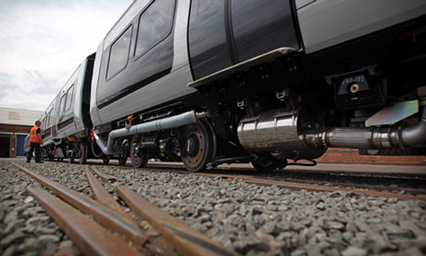

Caption:  Services to the Scottish Borders stopped when the Waverley line closed
Misinformation (Ground Truth): True
data loaded!
running llm-1...
================================== RESULT FROM LLM-1 ================================== 
USER:  
Caption: "Services to the Scottish Borders stopped when the Waverley line closed"

Your task is to determine whether the given caption accurately describes the image or not. 
Provide a detailed analysis explaining your reasoning behind your decision. 
Consider all relevant aspects, such as the watermarks, location markers, objects, actions, or scenes depicted in the image, and how well they align with the caption.

ASSISTANT: The caption "Services to the Scottish Borders stopped when the Waverley line closed" doesn't accurately describe the image. In the image, we can see a large train with a single engine car traveling on train tracks, but there is no clear indication of the train stopping at the Scottish Borders or the Waverley line. Furthermor

In [4]:
num_iters = 1
data_sample = 7
image, caption = get_data(data_sample)

print("data loaded!")
print("running llm-1...")

#result1 = get_initial_prediction(pipe1, image, caption)
prompt = """USER: <image>
Caption: "{}"

Your task is to determine whether the given caption accurately describes the image or not. 
Provide a detailed analysis explaining your reasoning behind your decision. 
Consider all relevant aspects, such as the watermarks, location markers, objects, actions, or scenes depicted in the image, and how well they align with the caption.

ASSISTANT:""".format(caption)
#prompt = "USER: <image>\nDoes the caption: \"{}\" match this image, why or why not?\nASSISTANT:".format(caption)
result1 = pipe1(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200, "do_sample": True, "temperature":0.7})
result1 = result1[0]["generated_text"]
print("================================== RESULT FROM LLM-1 ================================== \n{}\n ======================================================================================= ".format(result1))
print("running llm-2...")
result2 = pipe2(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200, "do_sample": True, "temperature": 0.7})
result2 = result2[0]["generated_text"]
print("================================== RESULT FROM LLM-2 ================================== \n{}\n ======================================================================================= ".format(result2))
print("COMMENCING DEBATE NOW...")
temp = result1
for i in range(num_iters):
    prompt = """USER: <image>
    Caption: "{}"

    This is the answer another AI agent generated for the same image and caption pair:
    "{}"
        
    Your task is to critically evaluate the other agent's response and provide a refined answer based on this new information. 
    If you agree with the other agent's assessment, explain why their reasoning is valid. 
    If you disagree, respectfully point out any potential flaws or counterarguments you have. 
    Aim to reach a more accurate and well-reasoned conclusion by incorporating insights from both perspectives.

    ASSISTANT:""".format(caption, result2[result2.find("ASSISTANT:")+len("ASSISTANT:"):])
    #prompt = """USER: <image>\nThis is the answer another AI agent generated for the same image and caption pair: \"{}\". 
    #                 Based on this new information, refine/change your answer as required and give reasons.\nASSISTANT:""".format(result2)
    result1 = pipe1(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200, "do_sample":True, "temperature":0.7})
    result1 = result1[0]["generated_text"]
    print("================================== RESULT FROM LLM-1 ================================== \n{}\n ======================================================================================= ".format(result1))
    prompt = """USER: <image>
    Caption: "{}"

    This is the answer another AI agent generated for the same image and caption pair:
    "{}"

    Your task is to critically evaluate the other agent's response and provide a refined answer based on this new information. 
    If you agree with the other agent's assessment, explain why their reasoning is valid. 
    If you disagree, respectfully point out any potential flaws or counterarguments you have. 
    Aim to reach a more accurate and well-reasoned conclusion by incorporating insights from both perspectives.

    ASSISTANT:""".format(caption, temp[temp.find("ASSISTANT:")+len("ASSISTANT:"):])
    #prompt = """USER: <image>\nThis is the answer another AI agent generated for the same image and caption pair: \"{}\". 
    #                 Based on this new information, refine your answer further and give reasons.\nASSISTANT:""".format(temp)
    result2 = pipe2(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200, "do_sample":True, "temperature":0.7})
    temp = result1
    result2 = result2[0]["generated_text"]
    print("================================== RESULT FROM LLM-2 ================================== \n{}\n ======================================================================================= ".format(result2))